In [1]:
!pip install --quiet transformers 
!pip install --quiet pytorch-lightning 

In [2]:
import seaborn as sns 
from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import textwrap
from pathlib import Path

import seaborn as sns
from tqdm.auto import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt 
from matplotlib import rc 
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/news-summary/news_summary_more.csv
/kaggle/input/news-summary/news_summary.csv


In [4]:
pl.seed_everything(42)

42

In [5]:
df = pd.read_csv('/kaggle/input/news-summary/news_summary.csv',encoding='latin-1')
df = df[['text','ctext']]
df.columns=["summary", "text"]
df=df.dropna()
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [6]:
train_df, test_df = train_test_split(df, test_size=0.1)
train_df.shape, test_df.shape

((3956, 2), (440, 2))

In [7]:
class NewsSummaryDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128):
        
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index:int):
        data_row = self.data.iloc[index]
        text = data_row["text"]
        
        text_encoding = tokenizer(data_row["text"],max_length=self.text_max_token_len,
                                 padding="max_length", 
                                 truncation=True,
                                 return_attention_mask=True,
                                 add_special_tokens=True,
                                 return_tensors="pt")
        
        summary = data_row["summary"]
        summary_encoding = tokenizer(summary,max_length=self.summary_max_token_len,
                                 padding="max_length", 
                                 truncation=True,
                                 return_attention_mask=True,
                                 add_special_tokens=True,
                                 return_tensors="pt")
        
        labels= summary_encoding["input_ids"] 
        labels[labels == 0] = -100
        
        return dict(
            text=text, 
            summary=summary,
            text_input_ids=text_encoding["input_ids"].flatten(),
            text_attention_mask=text_encoding["attention_mask"].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=summary_encoding["attention_mask"].flatten())
            

In [8]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(self, 
                train_df:pd.DataFrame,
                test_df:pd.DataFrame,
                tokenizer:T5Tokenizer,
                batch_size: int = 8,
                text_max_token_len: int = 512,
                summary_max_token_len: int = 128):
        super().__init__()
        self.train_df=train_df
        self.test_df=test_df
        
        self.batch_size=batch_size
        self.tokenizer=tokenizer
        self.text_max_token_len=text_max_token_len
        self.summary_max_token_len= summary_max_token_len
    
    def setup(self, stage=None):
        self.train_dataset =  NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_dataset =  NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2)
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2)
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2)
    
    

In [9]:
MODEL_NAME = "t5-base"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

In [10]:
text_token_counts, summary_token_counts = [],[]
for _, row in train_df.iterrows():
    text_token_count=len(tokenizer.encode(row['text']))
    text_token_counts.append(text_token_count)
    
    summary_token_count=len(tokenizer.encode(row['summary']))
    summary_token_counts.append(summary_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


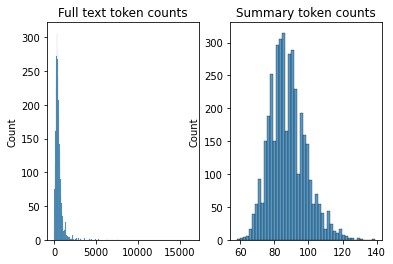

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.histplot(text_token_counts,ax=ax1)
ax1.set_title("Full text token counts")

sns.histplot(summary_token_counts,ax=ax2)
ax2.set_title("Summary token counts")

fig.show()


In [12]:
N_EPOCHS = 1
BATCH_SIZE = 8

data_module = NewsSummaryDataModule(train_df,test_df,tokenizer,batch_size=BATCH_SIZE)


# Model

In [13]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
        
    def forward(self, inputs_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(inputs_ids,
                            attention_mask=attention_mask,
                            labels=labels,
                            decoder_attention_mask=decoder_attention_mask)
        return output.loss, output.logits
    
    def step(self, batch, batch_idx):
        input_ids=batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels=batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self.forward(inputs_ids=input_ids,
                             attention_mask=attention_mask,
                             decoder_attention_mask=labels_attention_mask,
                             labels=labels)
        return loss, outputs
    
    def training_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        
        self.log("train_loss",loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        self.log("val_loss",loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        self.log("test_loss",loss, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)
    

In [14]:
model = NewsSummaryModel()

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [15]:
!kill 2079
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/bin/bash: line 0: kill: (2079) - No such process


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
checkpoint_callback = ModelCheckpoint(
                        dirpath="checkpoints",
                        filename="best-checkpoint",
                        save_top_k=1,
                        verbose=True, 
                        monitor="val_loss",
                        mode="min")
logger = TensorBoardLogger("lightning_logs", name="news-summary")

from pytorch_lightning.callbacks.progress import ProgressBar
class LitProgressBar(ProgressBar):

    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        bar.set_description('running validation ...')
        bar.refresh_rate=30
        return bar

bar = LitProgressBar()

trainer = pl.Trainer(logger=logger,
                    enable_checkpointing=checkpoint_callback,
                    max_epochs=N_EPOCHS,
                    gpus=1,
                    progress_bar_refresh_rate=30)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/progress/progress.py:24: LightningDeprecationWarning: `ProgressBar` has been deprecated in v1.5 and will be removed in v1.7. It has been renamed to `TQDMProgressBar` instead.
  "`ProgressBar` has been deprecated in v1.5 and will be removed in v1.7."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"


In [17]:
trainer.fit(model,data_module)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
    )

In [19]:
def summarize(text):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
        )
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding["input_ids"],
        attention_mask=text_encoding["attention_mask"],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True)
    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True) for gen_id in generated_ids
    ]
    return "".join(preds)
    

In [20]:
sample_row = test_df.iloc[69]
text = sample_row["text"]
ref_summary = sample_row["summary"]

model_summary = summarize(text)

print('Original text :  \n', text)
print('\nPredicted summary :  \n', model_summary)
print('\nOriginal summary :  \n', ref_summary)

Original text :  
 Archaeologists have unearthed a large, centuries-old statue that is believed to have once stood guard over an ancient hospital at Cambodia?s famed Angkor temple complex.The nearly two metre tall carving, which is thought to be from the late 12th to the early 13th century, was discovered during a dig on Saturday, said Long Kosal, a spokesman for Apsara Authority ? the state agency charged with managing the complex. The Angkor Archeological Park, a world heritage site, contains the remains of the different capitals of the Khmer Empire, dating from the 9th to the 15th centuries, and is Cambodia?s most popular tourist destination.At the height of its power the city and its hundreds of temples boasted more than a million inhabitants, making it one of the world?s most populous pre-industrial centres. Huge swathes of the park have been excavated over the decades, creating a walkable archaeological wonder that attracts more than two million visitors a year. But the complex r

In [21]:
text = 'Varanasi police commissioner A. Satish Ganesh told PTI that “Deployment (of security forces) has been made on the same scale as it was made on Saturday. Also attention has been paid to ensure that devotees visiting nearby areas do not face any problems (due to the survey). Our responsibility is that an ideal atmosphere is established, so that the court procedure can proceed without any hindrance.” Ahead of the commencement of the survey, Mr. Singh had told reporters that, “Efforts will be made so that the entire survey is completed today, and on May 17, the report can be presented before the court. District Magistrate Kaushal Raj Sharma had said on Saturday that almost 50% of the survey work has been done. “Survey of more than 50% of the place has been done. The survey work is confidential, and is done under the monitoring of the court. So, information regarding the places where the survey was done and what was found cannot be shared now,” he had said.'

model_summary = summarize(text)
print('\nPredicted summary :  \n', model_summary)


Predicted summary :  
 Varanasi police commissioner A Satish Ganesh on Saturday said, "Deployment (of security forces) has been made on the same scale as it was made on Saturday. Also attention has been paid to ensure that devotees visiting nearby areas do not face any problems (due to the survey). Our responsibility is that an ideal atmosphere is established so that the court procedure can proceed without any hindrance."
